In [1]:
import pandas as pd
import pyreadr
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Data pre-processing

In [2]:
# Import data
data_ml = pyreadr.read_r("data/data_ml.Rdata")
data_ml = data_ml["data_ml"]

# Data pre-processing
features = [
    "Ebit_Ta",
    "Eps",
    "Mkt_Cap_3M_Usd",
    "Mom_5M_Usd",
    "Pb",
    "Pe",
    "Total_Debt_Capital",
    "Vol1Y_Usd",
]
max_n_stocks = data_ml["stock_id"].value_counts().max()
data_ml = data_ml.loc[
    data_ml.groupby("stock_id").date.transform("count") == max_n_stocks
]
data_ml = data_ml.loc[data_ml["date"] >= pd.Timestamp("2005-01-01")]
data_ml["date"] = pd.to_datetime(data_ml["date"])
print("Shape of data: {data_ml.shape}")

# Starting point for backtest
sep_oos = pd.to_datetime("2010-01-01")

# Out of time dates
t_oos = data_ml.loc[data_ml["date"] > sep_oos, "date"].unique()
t_oos = pd.to_datetime(t_oos).sort_values()

Shape of data: {data_ml.shape}


# Model selection

In this section, we will be performing hyperparameter tuning for our ML models to be used in our backtesting. To avoid forward looking bias, we will be tuning using our training data from the first iteration in our backtesting. Instead of doing cross-validation, we will be segmenting a portion of this training data based on time and treat this as our validation set for our tuning process.

In [3]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from utils import MONTH_OFFSET, BT_TRAIN_SIZE


# Data prep
tune_dataset = data_ml[
    (data_ml["date"] < sep_oos - pd.Timedelta(days=MONTH_OFFSET * 30))
    & (
        data_ml["date"]
        > sep_oos - pd.Timedelta(days=MONTH_OFFSET * 30 + 365 * BT_TRAIN_SIZE)
    )
]
tune_dataset = tune_dataset.sort_values("date").reset_index(drop=True)
x = tune_dataset[features]
y = tune_dataset["R12M_Usd"] / np.exp(tune_dataset["Vol1Y_Usd"])
print(f"shape of training set: {x.shape}")

# Pre-determine split by latest year in tune dataset, 2008
split_index = tune_dataset[tune_dataset["date"].dt.year == 2008].index.min()
test_fold = [-1] * split_index + [0] * (len(x) - split_index)
ps = PredefinedSplit(test_fold)

shape of training set: (17856, 8)


## Regression

In [4]:
en_params = {"alpha": [0.001, 0.005, 0.01], "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
en_cv = GridSearchCV(
    ElasticNet(random_state=2025),
    en_params,
    scoring="neg_root_mean_squared_error",
    cv=ps,
)
en_cv.fit(x, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ElasticNet(random_state=2025),
             param_grid={'alpha': [0.001, 0.005, 0.01],
                         'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             scoring='neg_root_mean_squared_error')

In [5]:
cv_df = pd.DataFrame(en_cv.cv_results_)[
    ["params", "mean_test_score", "rank_test_score"]
]
cv_df = pd.concat(
    [cv_df["params"].apply(pd.Series), cv_df.drop(["params"], axis=1)], axis=1
)
cv_df.sort_values("rank_test_score")

,alpha,l1_ratio,mean_test_score,rank_test_score
0,0.001,0.0,-0.405557,1
1,0.001,0.1,-0.405655,2
7,0.005,0.0,-0.405686,3
14,0.010,0.0,-0.405837,4
2,0.001,0.3,-0.405852,5
3,0.001,0.5,-0.406042,6
8,0.005,0.1,-0.406181,7
4,0.001,0.7,-0.406239,8
5,0.001,0.9,-0.406445,9
6,0.001,1.0,-0.406552,10


The above table shows that the best validation score was achieved when alpha=0.001 and l2_ratio=0. However, I will be using the parameters alpha=0.01 and l2_ratio=0 at rank 4, as this applies a heavier regularization while barely reducing the validation rmse. This provide a more stable and generalizable solution for unseen data.

## XGBoost

In [6]:
test_params = {
    "max_depth": np.arange(5, 25, 5),
    "eta": np.array([0.001, 0.01, 0.05, 0.1]),
}
xgb_cv = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        subsample=0.5,
        min_child_weight=200,
        random_state=2025,
    ),
    param_grid=test_params,
    cv=ps,
    scoring="neg_root_mean_squared_error",
)
xgb_cv.fit(x, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=200, missing=nan,
                                    monotone

In [7]:
cv_df = pd.DataFrame(xgb_cv.cv_results_)[
    ["params", "mean_test_score", "rank_test_score"]
]
cv_df = pd.concat(
    [cv_df["params"].apply(pd.Series), cv_df.drop(["params"], axis=1)], axis=1
)
cv_df.sort_values("rank_test_score")

,eta,max_depth,mean_test_score,rank_test_score
11,0.050,20.0,-0.406089,1
9,0.050,10.0,-0.406150,2
8,0.050,5.0,-0.406315,3
10,0.050,15.0,-0.406428,4
4,0.010,5.0,-0.406608,5
6,0.010,15.0,-0.406662,6
7,0.010,20.0,-0.406662,6
5,0.010,10.0,-0.406691,8
14,0.100,15.0,-0.407167,9
12,0.100,5.0,-0.407224,10


Based on our results, we select the parameters eta=0.05 and max_depth=10 as the parameters looks reasonable, and the test scores do not differ a lot compared to the first choice.

# Portfolio backtesting

In this section, we perform the backtesting. To avoid forward looking bias from our features, we included a buffer period of one year between our train and test set. We also used a maximum training period of 5 years and iteratively shift the training dataset for each iteration.

Some important notes:
- Our benchmark will be an equally weighted portfolio including all stocks.
- We will be running our model against the risk-adjusted returns
- For each ML model, we will be train our model using our selected parameters from the previous section based on our risk-adjusted returns to speed up training. After using our models to predict the risk-adjusted returns, we will assign equal weights to the top 50 percentile of stocks with the highest predicted returns.

In [8]:
from utils import backtest

lr_params = {"l1_ratio": 0, "alpha": 0.01, "random_state": 2025}
xgb_params = {
    "eta": 0.05,
    "max_depth": 10,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "eval_metric": "rmse",
    "random_state": 2025,
}
portf_weights, portf_returns = backtest(
    data_ml, features, t_oos, lr_params=lr_params, xgb_params=xgb_params
)

2010-01-31 00:00:00
2011-01-31 00:00:00
2012-01-31 00:00:00
2013-01-31 00:00:00
2014-01-31 00:00:00
2015-01-31 00:00:00
2016-01-31 00:00:00
2017-01-31 00:00:00
2018-01-31 00:00:00
2019-01-31 00:00:00


# Results

In this section, we evaluate our models performance by considering returns of the portfolio, and turnover cost.

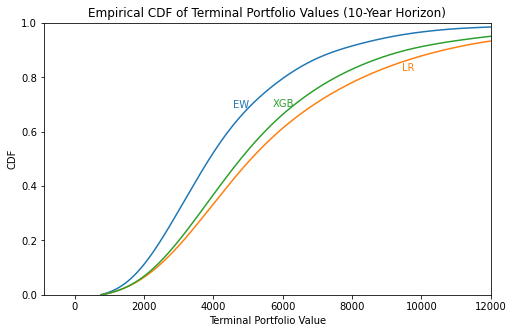

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,4391.1540,2393.3805
1,LR,0.5236,0.0149,0.0531,0.2814,5925.0682,3634.3338
2,XGB,0.6367,0.0143,0.0500,0.2850,5469.4617,3122.0486


In [9]:
from utils import perf_met_multi

# Block size of 1 year and 10 year time frame
blocksize_year = 1
p = 1 / (blocksize_year * 12)
timeframe = 10
metrics_df = perf_met_multi(
    portf_returns=portf_returns,
    portf_weights=portf_weights,
    asset_returns=data_ml,
    t_oos=t_oos,
    strat_name=["EW", "LR", "XGB"],
    time_period=timeframe,
    prob=p,
    xlim=12000,
    seed=2025,
)
metrics_df

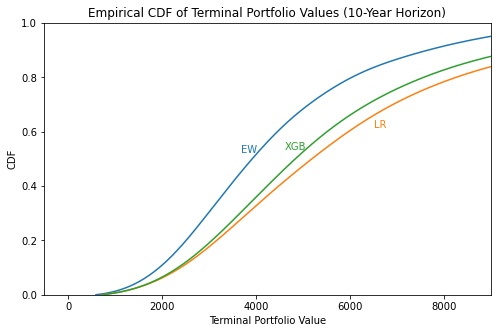

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,4384.4359,2241.4020
1,LR,0.5236,0.0149,0.0531,0.2814,5878.0828,3269.7758
2,XGB,0.6367,0.0143,0.0500,0.2850,5448.5360,2890.6039


In [11]:
# Block size of half a year and 10 year time frame
blocksize_year = 0.5
p = 1 / (blocksize_year * 12)
timeframe = 10
metrics_df = perf_met_multi(
    portf_returns=portf_returns,
    portf_weights=portf_weights,
    asset_returns=data_ml,
    t_oos=t_oos,
    strat_name=["EW", "LR", "XGB"],
    time_period=timeframe,
    prob=p,
    xlim=9000,
    seed=2025,
)
metrics_df

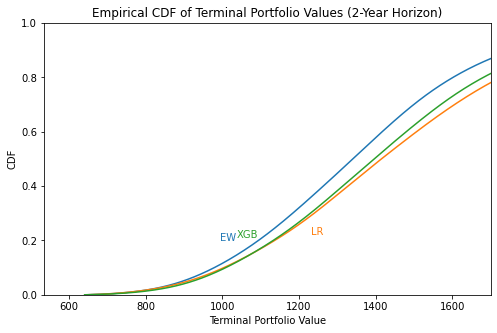

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,1358.3568,297.0083
1,LR,0.5236,0.0149,0.0531,0.2814,1444.6285,350.5432
2,XGB,0.6367,0.0143,0.0500,0.2850,1419.1575,322.9099


In [12]:
# Block size of a quarter and 2 year time frame
blocksize_year = 1 / 3
p = 1 / (blocksize_year * 12)
timeframe = 2
metrics_df = perf_met_multi(
    portf_returns=portf_returns,
    portf_weights=portf_weights,
    asset_returns=data_ml,
    t_oos=t_oos,
    strat_name=["EW", "LR", "XGB"],
    time_period=timeframe,
    prob=p,
    xlim=1700,
    seed=2025,
)
metrics_df